#### Step1. Extracting the data from MIMIC dataset by SQL queries:

In [73]:
import psycopg2 # Import the psycopg2 library to connect to a PostgreSQL database
import pandas as pd  

# Database connection details
dbname = 'mimic'
user = 'postgres'
password = '230391'
host = 'localhost'
search_path = 'mimiciii'

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, options=f'-c search_path={search_path}')

# Create a cursor object to interact with the database
cur = conn.cursor()

# Execute a SQL query to fetch the first 5 rows from the 'patients' table
cur.execute('SELECT * FROM patients LIMIT 5;')

# Fetch all rows from the executed query
rows = cur.fetchall()

# Create a DataFrame from the fetched rows and set column names based on the cursor description
df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])

# Close the cursor and the database connection
cur.close()
conn.close()

# Display the DataFrame
df

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13,NaT,NaT,None,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,None,1
2,236,251,M,2090-03-15,NaT,NaT,None,0
3,237,252,M,2078-03-06,NaT,NaT,None,0
4,238,253,F,2089-11-26,NaT,NaT,None,0


In [74]:
import psycopg2  
import pandas as pd  

# Database connection details
dbname = 'mimic'
user = 'postgres'
password = '230391'
host = 'localhost'
search_path = 'mimiciii'

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, options=f'-c search_path={search_path}')

# Create a cursor object to interact with the database
cur = conn.cursor()

# SQL query to aggregate notes for each patient
notes_query = """
SELECT subject_id, STRING_AGG(TEXT, ' ||| ') AS aggregated_notes
FROM noteevents
GROUP BY subject_id
"""

# SQL query to aggregate ICD codes for each patient
icd_query = """
SELECT subject_id, STRING_AGG(icd9_code, ', ') AS aggregated_icd_codes
FROM diagnoses_icd
GROUP BY subject_id
"""

# Create a temporary table for the aggregated notes
cur.execute(f"CREATE TEMP TABLE temp_notes AS {notes_query};")

# Create a temporary table for the aggregated ICD codes
cur.execute(f"CREATE TEMP TABLE temp_icd AS {icd_query};")

# SQL query to join the temporary tables on subject_id
join_query = """
SELECT tn.subject_id, tn.aggregated_notes, ti.aggregated_icd_codes
FROM temp_notes tn
JOIN temp_icd ti ON tn.subject_id = ti.subject_id
"""

# Execute the join query
cur.execute(join_query)

# Fetch all rows from the executed query
rows = cur.fetchall()

# Extract column names from the cursor description
columns = [desc[0] for desc in cur.description]

# Create a DataFrame from the fetched rows and set column names
df_patient_notes_icd = pd.DataFrame(rows, columns=columns)

# Close the cursor and the database connection
cur.close()
conn.close()

# Display the DataFrame
df_patient_notes_icd

,subject_id,aggregated_notes,aggregated_icd_codes
0,2,Nursing Transfer note\n\n\nPt admitted to NICU...,"V3001, V053, V290"
1,3,Admission Date: [**2101-10-20**] Discharg...,"0389, 78559, 5849, 4275, 41071, 4280, 6826, 42..."
2,4,Admission Date: [**2191-3-16**] Discharge...,"042, 1363, 7994, 2763, 7907, 5715, 04111, V090..."
3,5,NNP Triage Note\n\nBB [**Known lastname 6**] d...,"V3000, V053, V290"
4,6,Admission Date: [**2175-5-30**] Dischar...,"40391, 4440, 9972, 2766, 2767, 2859, 2753, V1582"
...,...,...,...
46141,99985,Admission Date: [**2181-1-27**] ...,"0389, 51881, 48241, 4870, 78552, V4281, 99592,..."
46142,99991,Admission Date: [**2184-12-24**] ...,"56211, 0389, 5570, 5849, 99592, 56081, 78959, ..."
46143,99992,Admission Date: [**2144-7-25**] ...,"9999, 56881, 5772, 2851, 5849, 5799, 72992, 53..."
46144,99995,Admission Date: [**2147-2-8**] D...,"4414, 42833, 99812, 2851, 4241, 25000, 99811, ..."


In [75]:
# List of ICD codes to filter
icd_codes_to_filter = [
    '30400', '30401', '30402', '30403', '3047', '30470', '30471', '30472', '30473',
    '3048', '30481', '30482', '30483', '30550', '30551', '30552', '30553',
    '96500', '96501', '96502', '96509', 'E8500', 'E9350'
]

# Function to check if the aggregated ICD codes contain any of the specified codes to filter
def contains_icd_code(aggregated_icd_codes):
    if aggregated_icd_codes is None:
        return False
    return any(code in aggregated_icd_codes.split(', ') for code in icd_codes_to_filter)

# Filter the DataFrame based on whether the aggregated ICD codes contain any of the specified codes
filtered_df = df_patient_notes_icd[df_patient_notes_icd['aggregated_icd_codes'].apply(contains_icd_code)]

# Display the filtered DataFrame
filtered_df

,subject_id,aggregated_notes,aggregated_icd_codes
56,64,Admission Date: [**2143-3-3**] Discharg...,"03811, 99591, 30400, 1120, 5111, 7895, 71107, ..."
69,78,Admission Date: [**2177-2-14**] Dischar...,"96500, 042, 07054, 5715, 30401, 2848, 9694, E8..."
96,106,Admission Date: [**2192-8-9**] D...,"42741, 3481, 5849, 78039, 2760, 30550, 4275, 4..."
99,109,Admission Date: [**2142-5-15**] ...,"40301, 486, 58281, 5855, 4254, 2762, 7100, 276..."
132,143,Admission Date: [**2155-1-17**] Dischar...,"1550, 5715, 57410, 07054, 30390, 30401, 2851, ..."
...,...,...,...
45695,98229,Admission Date: [**2121-3-3**] D...,"51881, 486, 49322, 41071, 5780, 2930, 27651, 7..."
45736,98389,Admission Date: [**2153-10-14**] ...,"29181, 5849, 7907, 6823, 2869, 2920, 30401, 30..."
46003,99444,Admission Date: [**2138-1-30**] ...,"96501, 51881, 5070, 5849, 48241, 78550, 30551,..."
46059,99659,Admission Date: [**2146-1-18**] ...,"4210, 42821, 7455, 04104, 3963, 07070, 311, 30..."


In [76]:
# Function to check if the aggregated ICD codes do not contain any of the specified codes to filter
def does_not_contain_icd_code(aggregated_icd_codes):
    if aggregated_icd_codes is None:
        return True
    return all(code not in aggregated_icd_codes.split(', ') for code in icd_codes_to_filter)

# Filter the DataFrame based on whether the aggregated ICD codes do not contain any of the specified codes
non_filtered_df = df_patient_notes_icd[df_patient_notes_icd['aggregated_icd_codes'].apply(does_not_contain_icd_code)]

# Print the non-filtered DataFrame
print(non_filtered_df)

       subject_id                                   aggregated_notes  \
0               2  Nursing Transfer note\n\n\nPt admitted to NICU...   
1               3  Admission Date:  [**2101-10-20**]     Discharg...   
2               4  Admission Date:  [**2191-3-16**]     Discharge...   
3               5  NNP Triage Note\n\nBB [**Known lastname 6**] d...   
4               6  Admission Date: [**2175-5-30**]        Dischar...   
...           ...                                                ...   
46141       99985  Admission Date:  [**2181-1-27**]              ...   
46142       99991  Admission Date:  [**2184-12-24**]             ...   
46143       99992  Admission Date:  [**2144-7-25**]              ...   
46144       99995  Admission Date:  [**2147-2-8**]              D...   
46145       99999  Admission Date:  [**2117-12-30**]             ...   

                                    aggregated_icd_codes  
0                                      V3001, V053, V290  
1      0389, 7855

In [78]:
# Randomly sample 1240 rows from the non-filtered DataFrame
# Set random_state for reproducibility
random_sample_non_filtered_df = non_filtered_df.sample(n=1240, random_state=42)

# Display the random sample of the non-filtered DataFrame
random_sample_non_filtered_df

,subject_id,aggregated_notes,aggregated_icd_codes
31963,45102,Admission Date: [**2156-1-11**] ...,"4241, 2851, V4581, 4019, 2720, 41401"
19513,20735,Admission Date: [**2168-3-20**] ...,"5304, 5119, 78820, 5192, 4019"
42457,85594,Admission Date: [**2201-5-26**] ...,"2252, 29411, 99811, 27652, 7100, 3568, 7810, 2..."
5650,5980,Newborn Med Attending\n\nAsked by Dr [**Last N...,"V3001, 7661, V290, V053"
39537,74232,Admission Date: [**2132-5-30**] ...,"44101, 2763, 4412, 40390, 5859, 2724, 41401, 3..."
...,...,...,...
43934,91343,Admission Date: [**2159-1-9**] D...,"42823, 51881, 34839, 9971, 99709, 99811, 3481,..."
3729,3955,Admission Date: [**2166-9-18**] ...,"41011, 4280, 42731, 53140, 53561, 41401, 42789..."
28765,30711,Admission Date: [**2114-3-2**] D...,"5533, 5118, 5180, 5121, 7504, 53081, 3004, 250..."
15965,16922,Admission Date: [**2171-12-16**] Discha...,"41401, 5121, 4019, 2720"


In [81]:
# Drop the 'aggregated_icd_codes' and 'subject_id' columns from the filtered DataFrame
filtered_df1 = filtered_df.drop(['aggregated_icd_codes', 'subject_id'], axis=1)

In [82]:
# Add a new column 'OUD condition' to the filtered DataFrame and set its value to 1
filtered_df1['OUD condition'] = 1

# Display the modified filtered DataFrame with the new column
filtered_df1

,aggregated_notes,OUD condition
56,Admission Date: [**2143-3-3**] Discharg...,1
69,Admission Date: [**2177-2-14**] Dischar...,1
96,Admission Date: [**2192-8-9**] D...,1
99,Admission Date: [**2142-5-15**] ...,1
132,Admission Date: [**2155-1-17**] Dischar...,1
...,...,...
45695,Admission Date: [**2121-3-3**] D...,1
45736,Admission Date: [**2153-10-14**] ...,1
46003,Admission Date: [**2138-1-30**] ...,1
46059,Admission Date: [**2146-1-18**] ...,1


In [83]:
# Drop the 'aggregated_icd_codes' and 'subject_id' columns from the random sample of the non-filtered DataFrame
random_sample_non_filtered_df1 = random_sample_non_filtered_df.drop(['aggregated_icd_codes', 'subject_id'], axis=1)

In [84]:
# Add a new column 'OUD condition' to the random sample of the non-filtered DataFrame and set its value to 0
random_sample_non_filtered_df1['OUD condition'] = 0

# Display the modified random sample of the non-filtered DataFrame with the new column
random_sample_non_filtered_df1

,aggregated_notes,OUD condition
31963,Admission Date: [**2156-1-11**] ...,0
19513,Admission Date: [**2168-3-20**] ...,0
42457,Admission Date: [**2201-5-26**] ...,0
5650,Newborn Med Attending\n\nAsked by Dr [**Last N...,0
39537,Admission Date: [**2132-5-30**] ...,0
...,...,...
43934,Admission Date: [**2159-1-9**] D...,0
3729,Admission Date: [**2166-9-18**] ...,0
28765,Admission Date: [**2114-3-2**] D...,0
15965,Admission Date: [**2171-12-16**] Discha...,0


In [85]:
# Concatenate the filtered DataFrame and the random sample of the non-filtered DataFrame
dataset = pd.concat([filtered_df1, random_sample_non_filtered_df1])

# Shuffle the concatenated dataset, reset the index, and set random_state for reproducibility
dataset1 = dataset.sample(frac=1, random_state=42, ignore_index=True)

# Display the final shuffled dataset
dataset1

,aggregated_notes,OUD condition
0,Admission Date: [**2155-11-14**] ...,0
1,Admission Date: [**2114-2-13**] ...,1
2,Neonatology NP Note\nInfant breathin comfortab...,0
3,Admission Date: [**2188-6-27**] ...,0
4,Unit No: [**Numeric Identifier 76043**]\nAdmi...,0
...,...,...
1995,Admission Date: [**2155-8-2**] D...,0
1996,Admission Date: [**2194-2-6**] D...,0
1997,Admission Date: [**2168-2-18**] Dischar...,0
1998,Admission Date: [**2176-1-16**] ...,0


In [86]:
# Shuffle the dataset again, reset the index, and set random_state for reproducibility
dataset1 = dataset1.sample(frac=1, random_state=42, ignore_index=True)

# Display the reshuffled dataset
dataset1

,aggregated_notes,OUD condition
0,Admission Date: [**2169-8-28**] ...,0
1,Admission Date: [**2154-12-31**] ...,0
2,Admission Date: [**2120-2-18**] ...,1
3,Admission Date: [**2145-8-6**] D...,0
4,Admission Date: [**2121-4-30**] ...,1
...,...,...
1995,Admission Date: [**2140-5-23**] ...,1
1996,Admission Date: [**2121-11-21**] Discha...,0
1997,Admission Date: [**2115-11-4**] Dischar...,0
1998,Admission Date: [**2141-6-27**] ...,0


In [2]:
# Save the final dataset (containing clinical notes for both OUD and non-OUD patients) to a CSV file
dataset1.to_csv('Clinical notes-OUD and non OUD.csv', index=False)

##### Now, we have a dataset including 2000 rows including 760 rows patients with OUD and 1240 rows patients without OUD and those are shuffled and randomly ordered.

#### Step2. importing the dataset to start the analysis

In [2]:
import nltk

In [3]:
# Import pandas for data manipulation and analysis
import pandas as pd

# Read the CSV file containing clinical notes for both OUD and non-OUD patients into a DataFrame
data = pd.read_csv('Clinical notes-OUD and non OUD.csv')

In [4]:
# Display the DataFrame
data

,aggregated_notes,OUD condition
0,Admission Date: [**2169-8-28**] ...,0
1,Admission Date: [**2154-12-31**] ...,0
2,Admission Date: [**2120-2-18**] ...,1
3,Admission Date: [**2145-8-6**] D...,0
4,Admission Date: [**2121-4-30**] ...,1
...,...,...
1995,Admission Date: [**2140-5-23**] ...,1
1996,Admission Date: [**2121-11-21**] Discha...,0
1997,Admission Date: [**2115-11-4**] Dischar...,0
1998,Admission Date: [**2141-6-27**] ...,0


In [5]:
# Check for missing values in the DataFrame and display the count of missing values for each column
data.isnull().sum()

aggregated_notes    0
OUD condition       0
dtype: int64

##### We write a function to clean and organize the notes to make them prepared for the analysis

In [6]:
def preprocess_text(text):
    # Import required libraries
    import re
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords

    # Remove extra whitespace and strip leading/trailing spaces
    text = re.sub('\s+', ' ', text).strip()

    # Replace newline characters with spaces and '|||' with newlines, then strip leading/trailing spaces
    text = text.replace('\n', ' ').replace('|||', '\n').strip()

    # Remove sequences of three or more underscores
    text = re.sub(r'_{3,}', '', text)

    # Remove sequences of three or more asterisks
    text = re.sub(r'\*{3,}', '', text)

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Get the set of English stopwords
    stop_words = set(stopwords.words('english'))

    # Filter out the stopwords from the tokens
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Return the list of filtered tokens
    return filtered_tokens


In [7]:
# Apply the preprocess_text function to the 'aggregated_notes' column to preprocess the text
# and create a new column 'Preprocessed Notes' with the filtered tokens
data['Preprocessed Notes'] = data['aggregated_notes'].apply(preprocess_text)

##### We import the lists of key words which we want to search them in the notes:

In [8]:
import pandas as pd  # Import pandas for data manipulation and analysis

# Read the Excel files containing various lists into DataFrames
Feelings = pd.read_excel('/Users/eshtiaghi/Desktop/Khashi/Chapman/NLP/Final project/Files/Opioid_Use_Disorder_Adjectives.xlsx')
disorders = pd.read_excel('/Users/eshtiaghi/Desktop/Khashi/Chapman/NLP/Final project/Files/Health_Issues_Associated_with_OUD_Patients.xlsx')
Analgesics = pd.read_excel('/Users/eshtiaghi/Desktop/Khashi/Chapman/NLP/Final project/Files/Medications/Analgesics_for_OUD_Patients.xlsx')
Psychiatric = pd.read_excel('/Users/eshtiaghi/Desktop/Khashi/Chapman/NLP/Final project/Files/Medications/Psychiatric_Medications_for_OUD_Patients.xlsx')
Withdrawal_Management = pd.read_excel('/Users/eshtiaghi/Desktop/Khashi/Chapman/NLP/Final project/Files/Medications/Withdrawal_Management_Medications_for_OUD_Patients.xlsx')
Adjunctive_and_Supportive = pd.read_excel('/Users/eshtiaghi/Desktop/Khashi/Chapman/NLP/Final project/Files/Medications/Adjunctive_and_Supportive_Care_Medications_for_OUD_Patients.xlsx')

# Convert specific columns of the DataFrames into lists
feelings_list = Feelings['Adjectives'].to_list()
disorders_list = disorders['Health Issues Associated with OUD'].to_list()
analgesics_list = Analgesics['Analgesics for OUD Patients'].to_list()
psychiatric_list = Psychiatric['Psychiatric Medications for OUD Patients'].to_list()
withdrawal_management_list = Withdrawal_Management['Withdrawal Management Medications'].to_list()
adjunctive_and_supportive_list = Adjunctive_and_Supportive['Adjunctive and Supportive Care Medications'].to_list()

#### Step3. We lemmatize the words of notes and words in our referece list as well in order to make sure some dicrepencies such as upper or lowercase, spacing, and misspelling do not avoid us from considering the words

In [9]:
# Import the WordNetLemmatizer from nltk
wnl = nltk.WordNetLemmatizer()

# Lemmatize the words in each list and convert them to lowercase
feelings_lem = [wnl.lemmatize(w.lower()) for w in feelings_list]
disorders_lem = [wnl.lemmatize(w.lower()) for w in disorders_list]
analgesics_lem = [wnl.lemmatize(w.lower()) for w in analgesics_list]
psychiatric_lem = [wnl.lemmatize(w.lower()) for w in psychiatric_list]
withdrawal_management_lem = [wnl.lemmatize(w.lower()) for w in withdrawal_management_list]
adjunctive_and_supportive_lem = [wnl.lemmatize(w.lower()) for w in adjunctive_and_supportive_list]

In [10]:
def extract_words(text, word_set):
    # Filter out non-alphabetic words from the text
    alpha_words = [w for w in text if w.isalpha()]

    # Create an instance of WordNetLemmatizer
    wnl = nltk.WordNetLemmatizer()

    # Lemmatize the alphabetic words and convert them to lowercase
    alpha_words_lem = [wnl.lemmatize(w.lower()) for w in alpha_words]

    # Return a set of words that are present in the given word_set
    return set(word for word in alpha_words_lem if word in word_set)

In [11]:
# Apply the extract_words function to the 'Preprocessed Notes' column for each word set and create new columns

# Extract patient feelings
data['Patient Feelings'] = data['Preprocessed Notes'].apply(lambda x: extract_words(x, feelings_lem))

# Extract patient disorders
data['Patient Disorders'] = data['Preprocessed Notes'].apply(lambda x: extract_words(x, disorders_lem))

# Extract patient analgesics medications
data['Patient Analgesics Medications'] = data['Preprocessed Notes'].apply(lambda x: extract_words(x, analgesics_lem))

# Extract patient psychiatric medications
data['Patient Psychiatric Medications'] = data['Preprocessed Notes'].apply(lambda x: extract_words(x, psychiatric_lem))

# Extract patient withdrawal management medications
data['Patient Withdrawal Management Medications'] = data['Preprocessed Notes'].apply(lambda x: extract_words(x, withdrawal_management_lem))

# Extract patient adjunctive and supportive medications
data['Patient Adjunctive and Supportive Medications'] = data['Preprocessed Notes'].apply(lambda x: extract_words(x, adjunctive_and_supportive_lem))

In [12]:
# Display the DataFrame with the new columns
data

,aggregated_notes,OUD condition,Preprocessed Notes,Patient Feelings,Patient Disorders,Patient Analgesics Medications,Patient Psychiatric Medications,Patient Withdrawal Management Medications,Patient Adjunctive and Supportive Medications
0,Admission Date: [**2169-8-28**] ...,0,"[Admission, Date, :, [, *, *, 2169-8-28, *, *,...","{angry, unstable, shocked, restless, lethargic...","{dizziness, anxiety, seizure, vascular, kidney...","{ibuprofen, morphine, fentanyl, aspirin}",{midazolam},{},"{folic, aspirin, thiamine, multivitamin, potas..."
1,Admission Date: [**2154-12-31**] ...,0,"[Admission, Date, :, [, *, *, 2154-12-31, *, *...","{scared, obscured, disoriented, lethargic, wit...","{dizziness, seizure, tuberculosis, abscess, pn...","{aspirin, morphine, lidocaine, acetaminophen, ...","{haloperidol, mirtazapine}","{haloperidol, ondansetron, mirtazapine, hydrox...","{iron, ciprofloxacin, aspirin, bisacodyl, sime..."
2,Admission Date: [**2120-2-18**] ...,1,"[Admission, Date, :, [, *, *, 2120-2-18, *, *,...","{embarrassed, pressured, ashamed, anxious, imp...","{neuropathy, bipolar, thrush, anxiety, hyperth...","{ibuprofen, lidocaine, acetaminophen}","{haloperidol, lorazepam, escitalopram, diazepam}","{haloperidol, lorazepam, escitalopram, diazepam}","{folic, metoclopramide, thiamine, senna}"
3,Admission Date: [**2145-8-6**] D...,0,"[Admission, Date, :, [, *, *, 2145-8-6, *, *, ...",{unresponsive},"{seizure, vascular, stroke, thrombosis, pneumo...",{fentanyl},{},{},{potassium}
4,Admission Date: [**2121-4-30**] ...,1,"[Admission, Date, :, [, *, *, 2121-4-30, *, *,...","{sensitive, unresponsive, suspicious}","{syncope, dizziness, anxiety, miscarriage, sei...",{},{},{},{}
...,...,...,...,...,...,...,...,...,...
1995,Admission Date: [**2140-5-23**] ...,1,"[Admission, Date, :, [, *, *, 2140-5-23, *, *,...","{distant, lethargic, agitated}","{dizziness, anxiety, cancer, obesity, schizoph...","{methadone, hydromorphone}",{lorazepam},"{lorazepam, methadone}",{}
1996,Admission Date: [**2121-11-21**] Discha...,0,"[Admission, Date, :, [, *, *, 2121-11-21, *, *...","{hesitant, irritable, passive, struggling}","{depression, hepatitis, pneumonia}",{},{},{},{iron}
1997,Admission Date: [**2115-11-4**] Dischar...,0,"[Admission, Date, :, [, *, *, 2115-11-4, *, *,...",{unstable},"{depression, nausea}",{},{},{},{}
1998,Admission Date: [**2141-6-27**] ...,0,"[Admission, Date, :, [, *, *, 2141-6-27, *, *,...","{suspicious, sensitive, anxious, distant, leth...","{anxiety, vascular, obesity, arrhythmia, kidne...","{morphine, aspirin}",{},{},"{magnesium, simethicone, potassium, aspirin}"


#### Step4. We count the number of each key word for each list in both OUD patients and non OUD patients

In [13]:
# Filter the DataFrame to create a new DataFrame for OUD patients
data_OUD = data[data['OUD condition'] == 1]

# Filter the DataFrame to create a new DataFrame for non-OUD patients
data_non_OUD = data[data['OUD condition'] == 0]

In [14]:
# List of columns to process
columns_to_process = [
    'Patient Feelings',
    'Patient Disorders',
    'Patient Analgesics Medications',
    'Patient Psychiatric Medications',
    'Patient Withdrawal Management Medications',
    'Patient Adjunctive and Supportive Medications'
]

# Dictionary to store the processed data for OUD patients
OUD_patients_data = {}

# Iterate over each column to process
for column_name in columns_to_process:
    # Get the data from the specified column as a list
    column_data = data_OUD[column_name].tolist()
    
    # Create a defaultdict to count occurrences of each item
    OUD_patients_column = defaultdict(int)
    
    # Iterate over each patient's data in the column
    for patient_data in column_data:
        # Iterate over each item in the patient's data
        for item in patient_data:
            # Increment the count for the item
            OUD_patients_column[item] += 1
    
    # Store the counted data in the dictionary with the column name as the key
    OUD_patients_data[column_name] = OUD_patients_column

In [16]:
# Dictionary to store the sorted data for OUD patients
OUD_patients_data_sorted = {}

# Iterate over each key-value pair in the OUD patients data dictionary
for key, value in OUD_patients_data.items():
    # Sort the items in the dictionary by their count in descending order
    sorted_values = dict(sorted(value.items(), key=lambda item: item[1], reverse=True))
    
    # Store the sorted dictionary in the OUD patients data sorted dictionary
    OUD_patients_data_sorted[key] = sorted_values

# Display the sorted data for OUD patients
OUD_patients_data_sorted

{'Patient Feelings': {'agitated': 361,
  'suspicious': 344,
  'lethargic': 288,
  'unresponsive': 287,
  'confused': 266,
  'anxious': 253,
  'depressed': 223,
  'restless': 183,
  'sensitive': 176,
  'obscured': 154,
  'withdrawn': 142,
  'distant': 135,
  'isolated': 120,
  'unstable': 116,
  'disoriented': 88,
  'angry': 64,
  'tense': 61,
  'fractured': 57,
  'frustrated': 52,
  'passive': 49,
  'fatigued': 45,
  'uncontrolled': 43,
  'intense': 37,
  'impulsive': 30,
  'paranoid': 28,
  'erratic': 28,
  'reluctant': 25,
  'suffering': 25,
  'distressed': 21,
  'depleted': 21,
  'irritable': 21,
  'guarded': 21,
  'shaky': 20,
  'scared': 19,
  'fragile': 19,
  'disconnected': 19,
  'trapped': 15,
  'shocked': 15,
  'needy': 14,
  'exhausted': 14,
  'driven': 14,
  'hesitant': 13,
  'struggling': 12,
  'overwhelmed': 12,
  'hopeless': 11,
  'pressured': 10,
  'strained': 10,
  'jittery': 10,
  'manipulative': 10,
  'frightened': 8,
  'fearful': 8,
  'impatient': 8,
  'turbulent': 8

In [15]:
# Dictionary to store the processed data for non-OUD patients
non_OUD_patients_data = {}

# Iterate over each column to process
for column_name in columns_to_process:
    # Get the data from the specified column as a list
    column_data = data_non_OUD[column_name].tolist()
    
    # Create a defaultdict to count occurrences of each item
    non_OUD_patients_column = defaultdict(int)
    
    # Iterate over each patient's data in the column
    for patient_data in column_data:
        # Iterate over each item in the patient's data
        for item in patient_data:
            # Increment the count for the item
            non_OUD_patients_column[item] += 1
    
    # Store the counted data in the dictionary with the column name as the key
    non_OUD_patients_data[column_name] = non_OUD_patients_column

In [17]:
# Dictionary to store the sorted data for non-OUD patients
non_OUD_patients_data_sorted = {}

# Iterate over each key-value pair in the non-OUD patients data dictionary
for key, value in non_OUD_patients_data.items():
    # Sort the items in the dictionary by their count in descending order
    sorted_values = dict(sorted(value.items(), key=lambda item: item[1], reverse=True))
    
    # Store the sorted dictionary in the non-OUD patients data sorted dictionary
    non_OUD_patients_data_sorted[key] = sorted_values

# Display the sorted data for non-OUD patients
non_OUD_patients_data_sorted

{'Patient Feelings': {'suspicious': 363,
  'agitated': 309,
  'anxious': 306,
  'confused': 295,
  'depressed': 284,
  'lethargic': 276,
  'unresponsive': 204,
  'unstable': 185,
  'restless': 178,
  'distant': 175,
  'obscured': 170,
  'sensitive': 170,
  'withdrawn': 143,
  'isolated': 115,
  'irritable': 100,
  'disoriented': 76,
  'fatigued': 61,
  'passive': 49,
  'frustrated': 42,
  'uncontrolled': 36,
  'distressed': 36,
  'intense': 35,
  'guarded': 35,
  'fragile': 34,
  'angry': 33,
  'tense': 33,
  'fractured': 32,
  'reluctant': 29,
  'erratic': 27,
  'depleted': 23,
  'disconnected': 23,
  'shocked': 22,
  'overwhelmed': 22,
  'suffering': 20,
  'exhausted': 19,
  'paranoid': 17,
  'scared': 14,
  'jittery': 14,
  'trapped': 13,
  'hesitant': 13,
  'struggling': 12,
  'grieving': 11,
  'reserved': 11,
  'frightened': 11,
  'brittle': 11,
  'driven': 10,
  'shaky': 9,
  'turbulent': 9,
  'fearful': 8,
  'impulsive': 7,
  'shattered': 7,
  'detached': 6,
  'needy': 6,
  'def

#### Step5. Drawing the plot of each category for OUD and non OUD patients

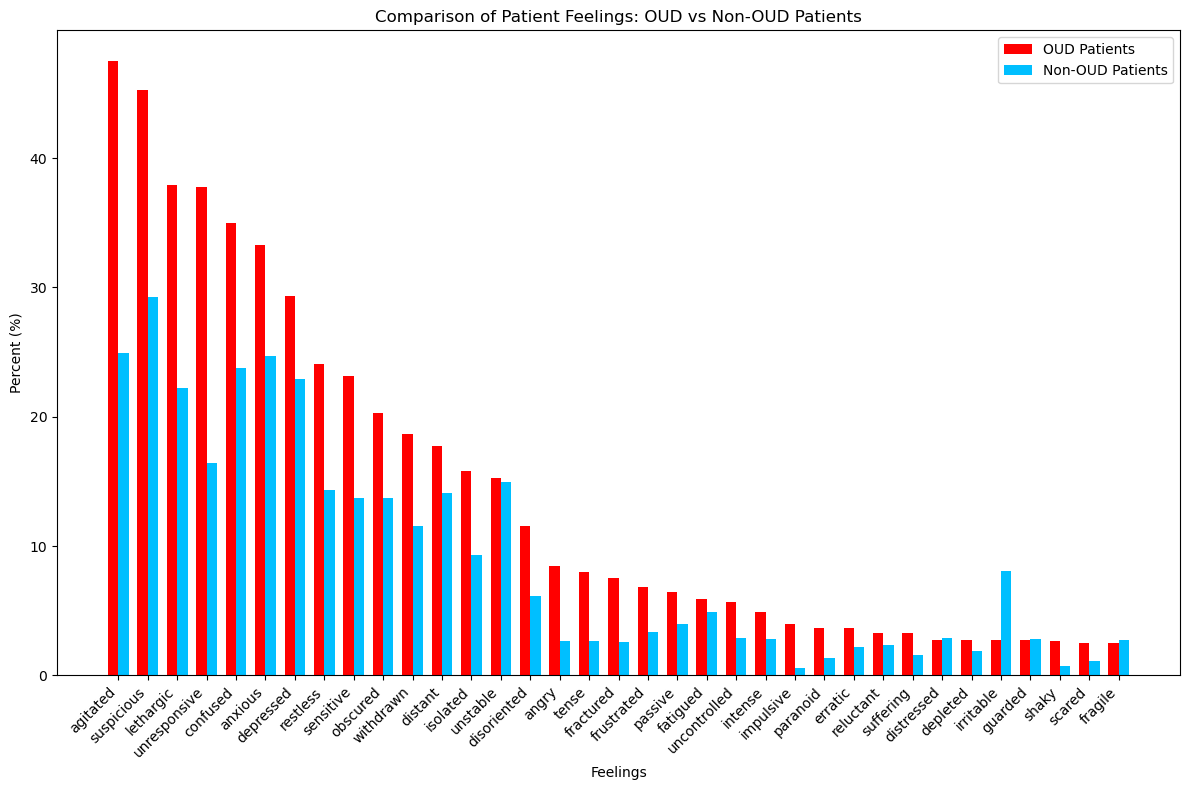

In [18]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Get the top 35 feelings from the sorted data for OUD patients
oud_feelings = list(OUD_patients_data_sorted['Patient Feelings'].keys())[:35]

# Calculate the percentage of each feeling for OUD patients
oud_percent = [x * 100 / 760 for x in list(OUD_patients_data_sorted['Patient Feelings'].values())[:35]]

# Initialize a list to store the counts of feelings for non-OUD patients
non_oud_counts = []

# Iterate over the top 35 feelings from OUD patients
for feeling in oud_feelings:
    # If the feeling is present in non-OUD patients, append its count; otherwise, append 0
    if feeling in non_OUD_patients_data_sorted['Patient Feelings']:
        non_oud_counts.append(non_OUD_patients_data_sorted['Patient Feelings'][feeling])
    else:
        non_oud_counts.append(0)

# Calculate the percentage of each feeling for non-OUD patients
non_oud_percent = [x * 100 / 1240 for x in non_oud_counts]

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of the bars
bar_width = 0.35

# Create an index for the x-axis
index = range(len(oud_feelings))

# Plot the bars for OUD patients
bar1 = ax.bar(index, oud_percent, bar_width, label='OUD Patients', color='red')

# Plot the bars for non-OUD patients, shifted to the right by bar_width
bar2 = ax.bar([i + bar_width for i in index], non_oud_percent, bar_width, label='Non-OUD Patients', color='deepskyblue')

# Set the labels and title of the plot
ax.set_xlabel('Feelings')
ax.set_ylabel('Percent (%)')
ax.set_title('Comparison of Patient Feelings: OUD vs Non-OUD Patients')

# Set the positions and labels of the x-ticks
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(oud_feelings, rotation=45, ha='right')

# Add a legend to the plot
ax.legend()

# Adjust the layout to fit everything
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('patient_feelings_comparison.jpg', format='jpeg', dpi=300)

# Display the plot
plt.show()

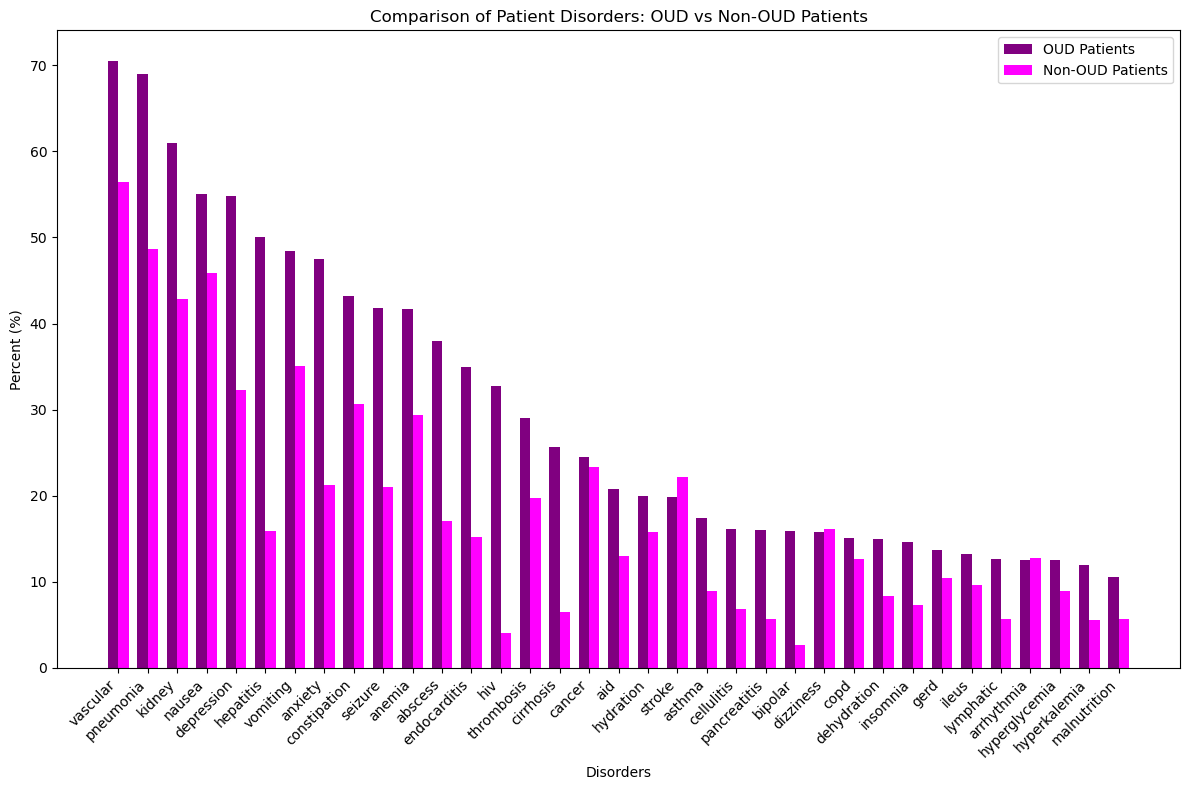

In [19]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Get the top 35 disorders from the sorted data for OUD patients
oud_disorders = list(OUD_patients_data_sorted['Patient Disorders'].keys())[:35]

# Calculate the percentage of each disorder for OUD patients
oud_percent = [x * 100 / 760 for x in list(OUD_patients_data_sorted['Patient Disorders'].values())[:35]]

# Initialize a list to store the counts of disorders for non-OUD patients
non_oud_counts = []

# Iterate over the top 35 disorders from OUD patients
for disorder in oud_disorders:
    # If the disorder is present in non-OUD patients, append its count; otherwise, append 0
    if disorder in non_OUD_patients_data_sorted['Patient Disorders']:
        non_oud_counts.append(non_OUD_patients_data_sorted['Patient Disorders'][disorder])
    else:
        non_oud_counts.append(0)

# Calculate the percentage of each disorder for non-OUD patients
non_oud_percent = [x * 100 / 1240 for x in non_oud_counts]

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of the bars
bar_width = 0.35

# Create an index for the x-axis
index = range(len(oud_disorders))

# Plot the bars for OUD patients
bar1 = ax.bar(index, oud_percent, bar_width, label='OUD Patients', color='purple')

# Plot the bars for non-OUD patients, shifted to the right by bar_width
bar2 = ax.bar([i + bar_width for i in index], non_oud_percent, bar_width, label='Non-OUD Patients', color='magenta')

# Set the labels and title of the plot
ax.set_xlabel('Disorders')
ax.set_ylabel('Percent (%)')
ax.set_title('Comparison of Patient Disorders: OUD vs Non-OUD Patients')

# Set the positions and labels of the x-ticks
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(oud_disorders, rotation=45, ha='right')

# Add a legend to the plot
ax.legend()

# Adjust the layout to fit everything
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('patient_disorders_comparison.jpg', format='jpeg', dpi=300)

# Display the plot
plt.show()

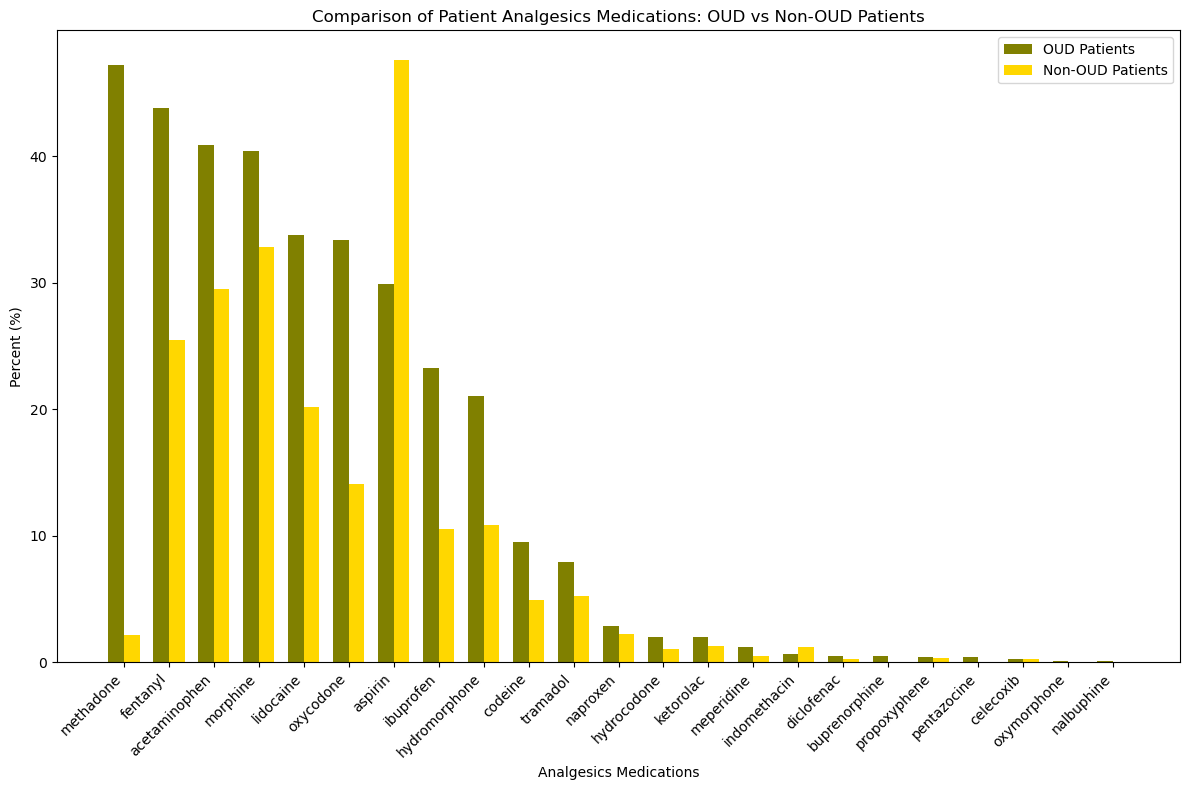

In [20]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Get the top 35 analgesics medications from the sorted data for OUD patients
oud_analgesics_medications = list(OUD_patients_data_sorted['Patient Analgesics Medications'].keys())[:35]

# Calculate the percentage of each analgesics medication for OUD patients
oud_percent = [x * 100 / 760 for x in list(OUD_patients_data_sorted['Patient Analgesics Medications'].values())[:35]]

# Initialize a list to store the counts of analgesics medications for non-OUD patients
non_oud_counts = []

# Iterate over the top 35 analgesics medications from OUD patients
for analgesics_medication in oud_analgesics_medications:
    # If the analgesics medication is present in non-OUD patients, append its count; otherwise, append 0
    if analgesics_medication in non_OUD_patients_data_sorted['Patient Analgesics Medications']:
        non_oud_counts.append(non_OUD_patients_data_sorted['Patient Analgesics Medications'][analgesics_medication])
    else:
        non_oud_counts.append(0)

# Calculate the percentage of each analgesics medication for non-OUD patients
non_oud_percent = [x * 100 / 1240 for x in non_oud_counts]

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of the bars
bar_width = 0.35

# Create an index for the x-axis
index = range(len(oud_analgesics_medications))

# Plot the bars for OUD patients
bar1 = ax.bar(index, oud_percent, bar_width, label='OUD Patients', color='olive')

# Plot the bars for non-OUD patients, shifted to the right by bar_width
bar2 = ax.bar([i + bar_width for i in index], non_oud_percent, bar_width, label='Non-OUD Patients', color='gold')

# Set the labels and title of the plot
ax.set_xlabel('Analgesics Medications')
ax.set_ylabel('Percent (%)')
ax.set_title('Comparison of Patient Analgesics Medications: OUD vs Non-OUD Patients')

# Set the positions and labels of the x-ticks
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(oud_analgesics_medications, rotation=45, ha='right')

# Add a legend to the plot
ax.legend()

# Adjust the layout to fit everything
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('patient_analgesics_comparison.jpg', format='jpeg', dpi=300)

# Display the plot
plt.show()

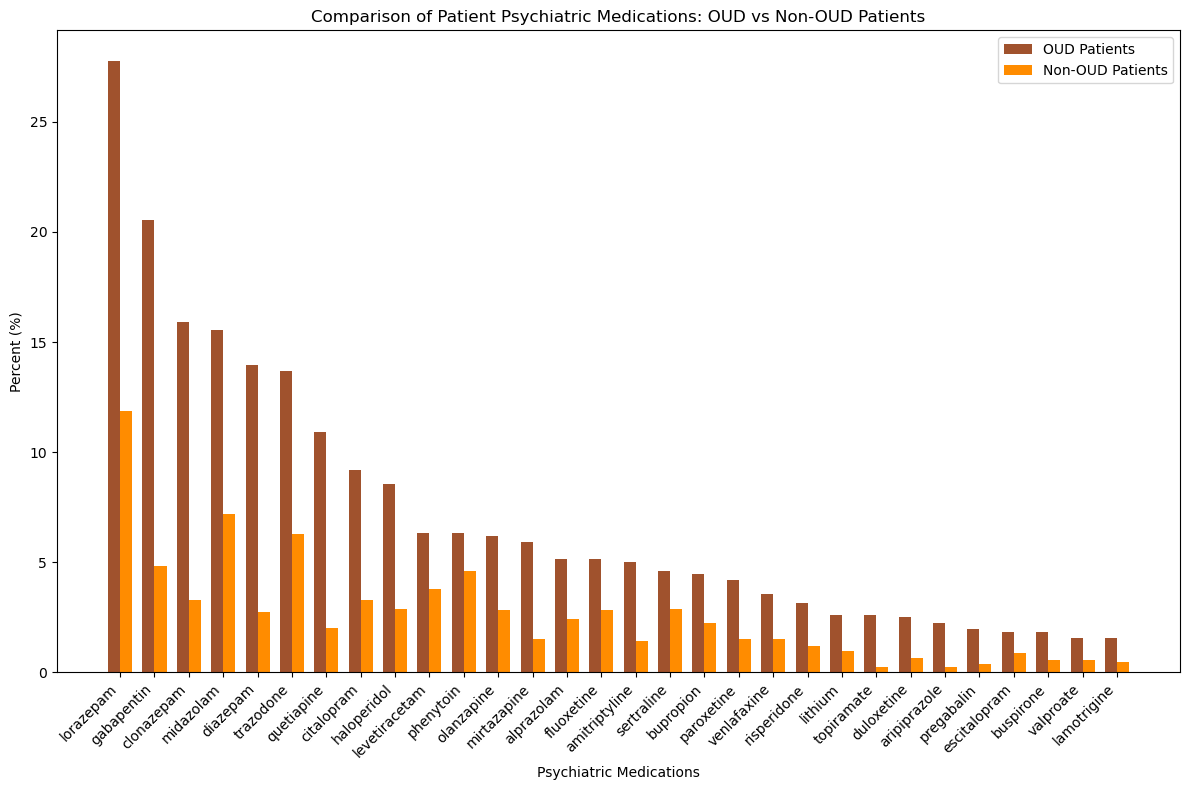

In [21]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Get the top 30 psychiatric medications from the sorted data for OUD patients
oud_psychiatric_medications = list(OUD_patients_data_sorted['Patient Psychiatric Medications'].keys())[:30]

# Calculate the percentage of each psychiatric medication for OUD patients
oud_percent = [x * 100 / 760 for x in list(OUD_patients_data_sorted['Patient Psychiatric Medications'].values())[:30]]

# Initialize a list to store the counts of psychiatric medications for non-OUD patients
non_oud_counts = []

# Iterate over the top 30 psychiatric medications from OUD patients
for psychiatric_medication in oud_psychiatric_medications:
    # If the psychiatric medication is present in non-OUD patients, append its count; otherwise, append 0
    if psychiatric_medication in non_OUD_patients_data_sorted['Patient Psychiatric Medications']:
        non_oud_counts.append(non_OUD_patients_data_sorted['Patient Psychiatric Medications'][psychiatric_medication])
    else:
        non_oud_counts.append(0)

# Calculate the percentage of each psychiatric medication for non-OUD patients
non_oud_percent = [x * 100 / 1240 for x in non_oud_counts]

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of the bars
bar_width = 0.35

# Create an index for the x-axis
index = range(len(oud_psychiatric_medications))

# Plot the bars for OUD patients
bar1 = ax.bar(index, oud_percent, bar_width, label='OUD Patients', color='sienna')

# Plot the bars for non-OUD patients, shifted to the right by bar_width
bar2 = ax.bar([i + bar_width for i in index], non_oud_percent, bar_width, label='Non-OUD Patients', color='darkorange')

# Set the labels and title of the plot
ax.set_xlabel('Psychiatric Medications')
ax.set_ylabel('Percent (%)')
ax.set_title('Comparison of Patient Psychiatric Medications: OUD vs Non-OUD Patients')

# Set the positions and labels of the x-ticks
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(oud_psychiatric_medications, rotation=45, ha='right')

# Add a legend to the plot
ax.legend()

# Adjust the layout to fit everything
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('patient_psychiatric_medications_comparison.jpg', format='jpeg', dpi=300)

# Display the plot
plt.show()

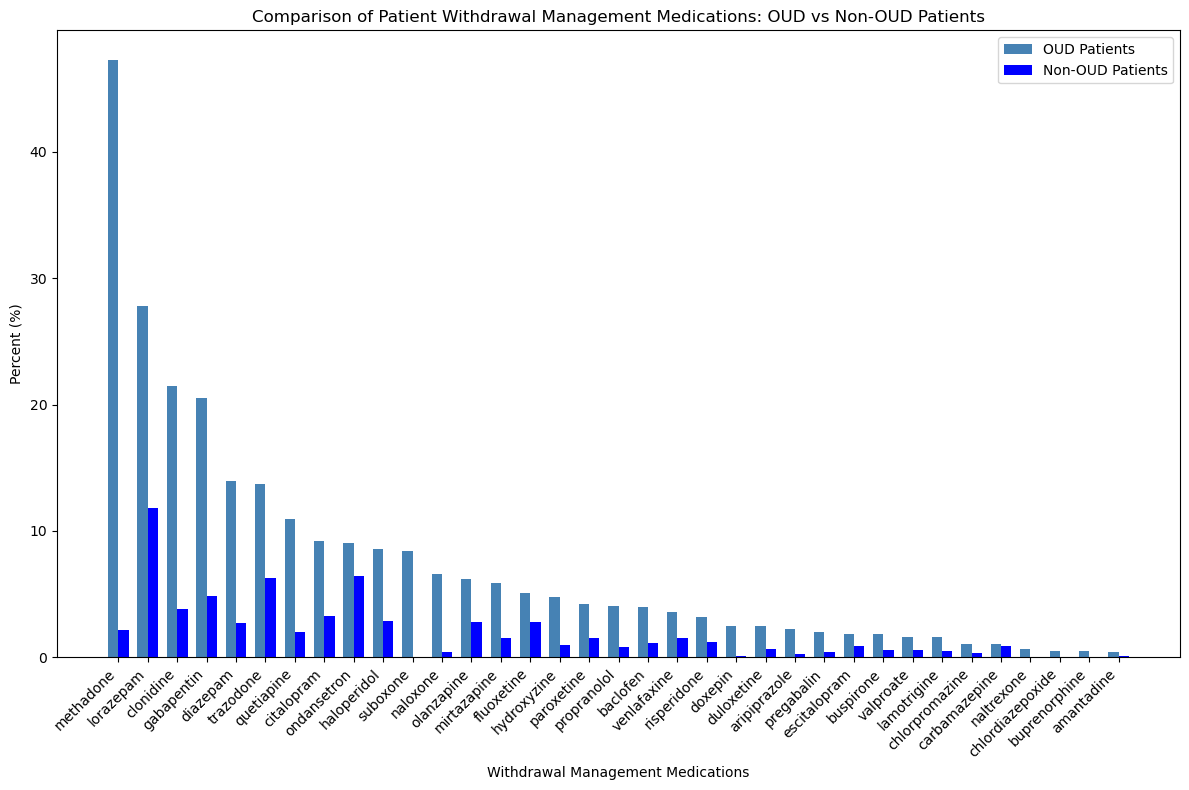

In [22]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Get the top 35 withdrawal management medications from the sorted data for OUD patients
oud_withdrawal_management_medications = list(OUD_patients_data_sorted['Patient Withdrawal Management Medications'].keys())[:35]

# Calculate the percentage of each withdrawal management medication for OUD patients
oud_percent = [x * 100 / 760 for x in list(OUD_patients_data_sorted['Patient Withdrawal Management Medications'].values())[:35]]

# Initialize a list to store the counts of withdrawal management medications for non-OUD patients
non_oud_counts = []

# Iterate over the top 35 withdrawal management medications from OUD patients
for withdrawal_management_medication in oud_withdrawal_management_medications:
    # If the withdrawal management medication is present in non-OUD patients, append its count; otherwise, append 0
    if withdrawal_management_medication in non_OUD_patients_data_sorted['Patient Withdrawal Management Medications']:
        non_oud_counts.append(non_OUD_patients_data_sorted['Patient Withdrawal Management Medications'][withdrawal_management_medication])
    else:
        non_oud_counts.append(0)

# Calculate the percentage of each withdrawal management medication for non-OUD patients
non_oud_percent = [x * 100 / 1240 for x in non_oud_counts]

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of the bars
bar_width = 0.35

# Create an index for the x-axis
index = range(len(oud_withdrawal_management_medications))

# Plot the bars for OUD patients
bar1 = ax.bar(index, oud_percent, bar_width, label='OUD Patients', color='steelblue')

# Plot the bars for non-OUD patients, shifted to the right by bar_width
bar2 = ax.bar([i + bar_width for i in index], non_oud_percent, bar_width, label='Non-OUD Patients', color='blue')

# Set the labels and title of the plot
ax.set_xlabel('Withdrawal Management Medications')
ax.set_ylabel('Percent (%)')
ax.set_title('Comparison of Patient Withdrawal Management Medications: OUD vs Non-OUD Patients')

# Set the positions and labels of the x-ticks
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(oud_withdrawal_management_medications, rotation=45, ha='right')

# Add a legend to the plot
ax.legend()

# Adjust the layout to fit everything
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('patient_withdrawal_medications_comparison.jpg', format='jpeg', dpi=300)

# Display the plot
plt.show()

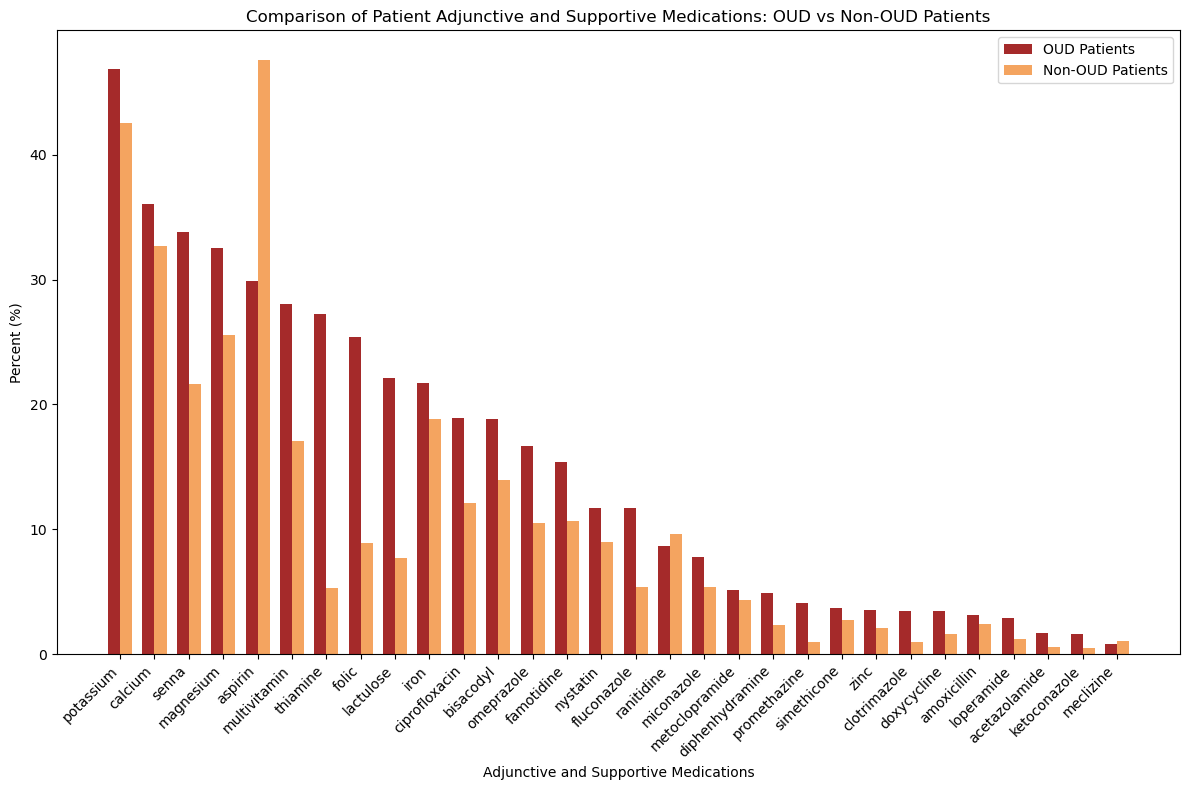

In [23]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Get the top 30 adjunctive and supportive medications from the sorted data for OUD patients
oud_adjunctive_supportive_medications = list(OUD_patients_data_sorted['Patient Adjunctive and Supportive Medications'].keys())[:30]

# Calculate the percentage of each adjunctive and supportive medication for OUD patients
oud_percent = [x * 100 / 760 for x in list(OUD_patients_data_sorted['Patient Adjunctive and Supportive Medications'].values())[:30]]

# Initialize a list to store the counts of adjunctive and supportive medications for non-OUD patients
non_oud_counts = []

# Iterate over the top 30 adjunctive and supportive medications from OUD patients
for adjunctive_supportive_medication in oud_adjunctive_supportive_medications:
    # If the adjunctive and supportive medication is present in non-OUD patients, append its count; otherwise, append 0
    if adjunctive_supportive_medication in non_OUD_patients_data_sorted['Patient Adjunctive and Supportive Medications']:
        non_oud_counts.append(non_OUD_patients_data_sorted['Patient Adjunctive and Supportive Medications'][adjunctive_supportive_medication])
    else:
        non_oud_counts.append(0)

# Calculate the percentage of each adjunctive and supportive medication for non-OUD patients
non_oud_percent = [x * 100 / 1240 for x in non_oud_counts]

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the width of the bars
bar_width = 0.35

# Create an index for the x-axis
index = range(len(oud_adjunctive_supportive_medications))

# Plot the bars for OUD patients
bar1 = ax.bar(index, oud_percent, bar_width, label='OUD Patients', color='brown')

# Plot the bars for non-OUD patients, shifted to the right by bar_width
bar2 = ax.bar([i + bar_width for i in index], non_oud_percent, bar_width, label='Non-OUD Patients', color='sandybrown')

# Set the labels and title of the plot
ax.set_xlabel('Adjunctive and Supportive Medications')
ax.set_ylabel('Percent (%)')
ax.set_title('Comparison of Patient Adjunctive and Supportive Medications: OUD vs Non-OUD Patients')

# Set the positions and labels of the x-ticks
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(oud_adjunctive_supportive_medications, rotation=45, ha='right')

# Add a legend to the plot
ax.legend()

# Adjust the layout to fit everything
plt.tight_layout()

# Save the plot as a JPEG file
plt.savefig('patient_adjunctive_medications_comparison.jpg', format='jpeg', dpi=300)

# Display the plot
plt.show()

#### Step6. Building models to predict if a note belongs to OUD patient or non OUD patient

In [24]:
# Combine all lemmatized lists into a single set to create a unique set of patient features
patient_features_list = set(characteristics_lem + disorders_lem + analgesics_lem + psychiatric_lem + withdrawal_management_lem + adjunctive_and_supportive_lem)

In [25]:
#The number of unique features
len(patient_features_list)

278

In [4]:
# Display the set of patient features
patient_features_list

In [27]:
data

,aggregated_notes,OUD condition,Preprocessed Notes,Patient Feelings,Patient Disorders,Patient Analgesics Medications,Patient Psychiatric Medications,Patient Withdrawal Management Medications,Patient Adjunctive and Supportive Medications
0,Admission Date: [**2169-8-28**] ...,0,"[Admission, Date, :, [, *, *, 2169-8-28, *, *,...","{angry, unstable, shocked, restless, lethargic...","{dizziness, anxiety, seizure, vascular, kidney...","{ibuprofen, morphine, fentanyl, aspirin}",{midazolam},{},"{folic, aspirin, thiamine, multivitamin, potas..."
1,Admission Date: [**2154-12-31**] ...,0,"[Admission, Date, :, [, *, *, 2154-12-31, *, *...","{scared, obscured, disoriented, lethargic, wit...","{dizziness, seizure, tuberculosis, abscess, pn...","{aspirin, morphine, lidocaine, acetaminophen, ...","{haloperidol, mirtazapine}","{haloperidol, ondansetron, mirtazapine, hydrox...","{iron, ciprofloxacin, aspirin, bisacodyl, sime..."
2,Admission Date: [**2120-2-18**] ...,1,"[Admission, Date, :, [, *, *, 2120-2-18, *, *,...","{embarrassed, pressured, ashamed, anxious, imp...","{neuropathy, bipolar, thrush, anxiety, hyperth...","{ibuprofen, lidocaine, acetaminophen}","{haloperidol, lorazepam, escitalopram, diazepam}","{haloperidol, lorazepam, escitalopram, diazepam}","{folic, metoclopramide, thiamine, senna}"
3,Admission Date: [**2145-8-6**] D...,0,"[Admission, Date, :, [, *, *, 2145-8-6, *, *, ...",{unresponsive},"{seizure, vascular, stroke, thrombosis, pneumo...",{fentanyl},{},{},{potassium}
4,Admission Date: [**2121-4-30**] ...,1,"[Admission, Date, :, [, *, *, 2121-4-30, *, *,...","{sensitive, unresponsive, suspicious}","{syncope, dizziness, anxiety, miscarriage, sei...",{},{},{},{}
...,...,...,...,...,...,...,...,...,...
1995,Admission Date: [**2140-5-23**] ...,1,"[Admission, Date, :, [, *, *, 2140-5-23, *, *,...","{distant, lethargic, agitated}","{dizziness, anxiety, cancer, obesity, schizoph...","{methadone, hydromorphone}",{lorazepam},"{lorazepam, methadone}",{}
1996,Admission Date: [**2121-11-21**] Discha...,0,"[Admission, Date, :, [, *, *, 2121-11-21, *, *...","{hesitant, irritable, passive, struggling}","{depression, hepatitis, pneumonia}",{},{},{},{iron}
1997,Admission Date: [**2115-11-4**] Dischar...,0,"[Admission, Date, :, [, *, *, 2115-11-4, *, *,...",{unstable},"{depression, nausea}",{},{},{},{}
1998,Admission Date: [**2141-6-27**] ...,0,"[Admission, Date, :, [, *, *, 2141-6-27, *, *,...","{suspicious, sensitive, anxious, distant, leth...","{anxiety, vascular, obesity, arrhythmia, kidne...","{morphine, aspirin}",{},{},"{magnesium, simethicone, potassium, aspirin}"


##### Making the featuresets to train a Naive Bayes Classifier:

In [28]:
def patient_features(text):
    # Filter out non-alphabetic words from the text
    alpha_words = [w for w in text if w.isalpha()]
    
    # Create an instance of WordNetLemmatizer
    wnl = nltk.WordNetLemmatizer()
    
    # Lemmatize the alphabetic words and convert them to lowercase
    alpha_words_lem = [wnl.lemmatize(w.lower()) for w in alpha_words]
    
    # Initialize a dictionary to store the features
    features = {}
    
    # Iterate over each feature in the patient_features_list
    for feature in patient_features_list:
        # Count the occurrences of the feature in the lemmatized words
        features["count({})".format(feature)] = alpha_words_lem.count(feature)
        # Check if the feature is present in the lemmatized words
        features["has({})".format(feature)] = (feature in alpha_words_lem)
    
    # Return the features dictionary
    return features

In [29]:
# Create a list of feature sets for the first 2000 entries in the DataFrame
# Each feature set is a tuple containing the feature dictionary and the corresponding OUD condition
featuresets = [(patient_features(data['Preprocessed Notes'][n]), data['OUD condition'][n]) for n in range(2000)]

In [30]:
# Split the feature sets into a training set and a test set
# The training set contains the first 1600 entries
# The test set contains the remaining entries
train_set, test_set = featuresets[:1600], featuresets[1600:]

In [31]:
# Train a Naive Bayes classifier using the training set
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [32]:
# Calculate and display the accuracy of the classifier on the test set
nltk.classify.accuracy(classifier, test_set)

0.7725

##### Importing libraries and prepare the train and test sets to make other models:

In [33]:
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data
from sklearn.feature_extraction.text import CountVectorizer  # Import CountVectorizer for text vectorization
from sklearn.naive_bayes import MultinomialNB  # Import MultinomialNB for Naive Bayes classifier
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression for logistic regression classifier
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier for random forest classifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score  # Import metrics for model evaluation

In [34]:
# Extract the features (preprocessed notes) and target variable (OUD condition)
X = data['Preprocessed Notes'] 
y = data['OUD condition']  

# Split the data into training and testing sets, with 25% of the data used for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert the list of tokens in each document to a single string for vectorization
X_train = [' '.join(doc) for doc in X_train]
X_test = [' '.join(doc) for doc in X_test]

In [35]:
# Initialize the CountVectorizer with a maximum of 4000 features
vectorizer = CountVectorizer(max_features=4000)

# Fit the vectorizer to the training data and transform the training data into feature vectors
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the testing data into feature vectors using the fitted vectorizer
X_test_vec = vectorizer.transform(X_test)

### MultinomialNB:

In [38]:
# Initialize the Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()

# Fit the classifier to the training data
mnb_classifier.fit(X_train_vec, y_train)
        
# Predict the labels for the test data
y_pred = mnb_classifier.predict(X_test_vec)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the precision of the classifier
precision = precision_score(y_test, y_pred, average='binary') 

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='binary') 

# Calculate the F1 score of the classifier
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.79
Precision: 0.6991150442477876
Recall: 0.8102564102564103
F1 Score: 0.7505938242280285


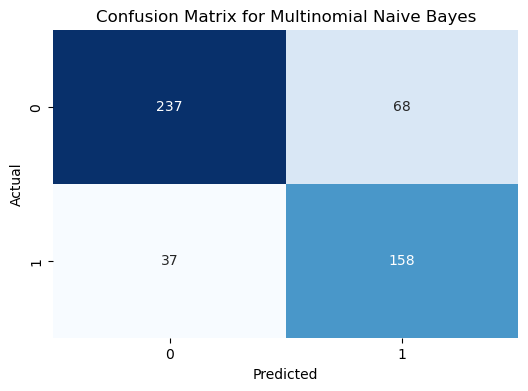

In [40]:
#using Seaborn, plot confusion matrix for multinomial naive bayes
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for Multinomial Naive Bayes")
plt.show()

### Logistic Regression:

In [41]:
# Initialize the Logistic Regression classifier with a maximum of 2000 iterations
log_classifier = LogisticRegression(max_iter=2000)

# Fit the classifier to the training data
log_classifier.fit(X_train_vec, y_train)
        
# Predict the labels for the test data
y_pred = log_classifier.predict(X_test_vec)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the precision of the classifier
precision = precision_score(y_test, y_pred, average='binary') 

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='binary') 

# Calculate the F1 score of the classifier
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.844
Precision: 0.8268156424581006
Recall: 0.7589743589743589
F1 Score: 0.7914438502673796


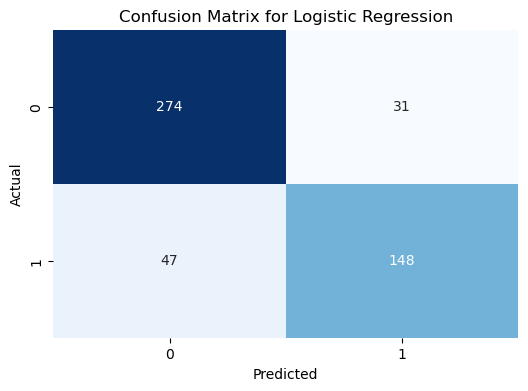

In [42]:
#using Seaborn, plot confusion matrix for logistic regression
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for Logistic Regression")
plt.show()

### Random Forest:

In [43]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier to the training data
rf_classifier.fit(X_train_vec, y_train)

# Predict the labels for the test data
y_pred = rf_classifier.predict(X_test_vec)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the precision of the classifier
precision = precision_score(y_test, y_pred, average='binary') 

# Calculate the recall of the classifier
recall = recall_score(y_test, y_pred, average='binary') 

# Calculate the F1 score of the classifier
f1 = f1_score(y_test, y_pred, average='binary')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', conf_matrix)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.898
Precision: 0.86
Recall: 0.882051282051282
F1 Score: 0.8708860759493672


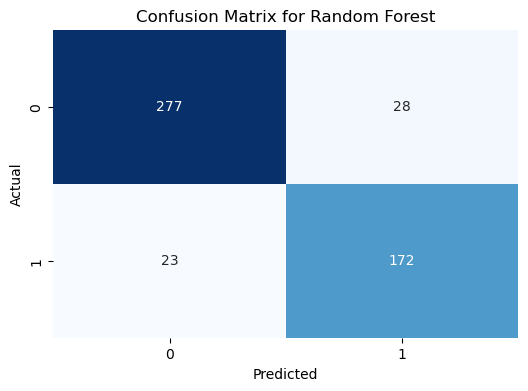

In [44]:
#using Seaborn, plot confusion matrix for random forest
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for Random Forest")
plt.show()